In [168]:
import pickle
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from requests import get
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [169]:
news = get('http://localhost:9200/slashnews/scraped/_search?sort=date:desc&size=3000').json()

In [170]:
df = pd.io.json.json_normalize(news['hits']['hits'])

In [182]:
df.head(1).T

,0
body,Swedish Social Services and Sports Minister An...
subject,Swedish minister supports Turkish-origin footb...
language,English
categories,Sports


## Common issues that we generally face during the data preparation phase:
 - Format and structure normalization
 - Detect and fix missing values
 - Duplicates removal
 - Units normalization
 - Constraints validations
 - Anomaly detection and removal
 - Study of features importance/relevance
 - Dimentional reduction, feature selection & extraction

In [172]:
df = df[['_source.body', '_source.subject', '_source.language', '_source.categories']]

In [173]:
df.head(1).T

,0
_source.body,Swedish Social Services and Sports Minister An...
_source.subject,Swedish minister supports Turkish-origin footb...
_source.language,English
_source.categories,Sports


In [174]:
df.columns = ['body', 'subject', 'language', 'categories']
df = df[pd.notnull(df['body'])]

In [175]:
df.head(1).T

,0
body,Swedish Social Services and Sports Minister An...
subject,Swedish minister supports Turkish-origin footb...
language,English
categories,Sports


In [176]:
def lst2str(x):
    if isinstance(x,(list, tuple)) or (',' in x):
        return ','.join(x)
    return x

In [177]:
# df['categories'] = df['categories'].apply(lst2str)

In [178]:
df.head(1).T

,0
body,Swedish Social Services and Sports Minister An...
subject,Swedish minister supports Turkish-origin footb...
language,English
categories,Sports


In [179]:
df = df[df.categories != 'News']
df = df[df.categories != 'Turkey']
df = df[df.categories != 'BUSINESS']
df = df[df.categories != 'Uncategorized']

In [180]:
df.groupby('categories')['categories'].count().value_counts(ascending=False)

1     101
2       8
3       5
4       2
87      1
81      1
56      1
47      1
32      1
30      1
20      1
12      1
8       1
6       1
Name: categories, dtype: int64

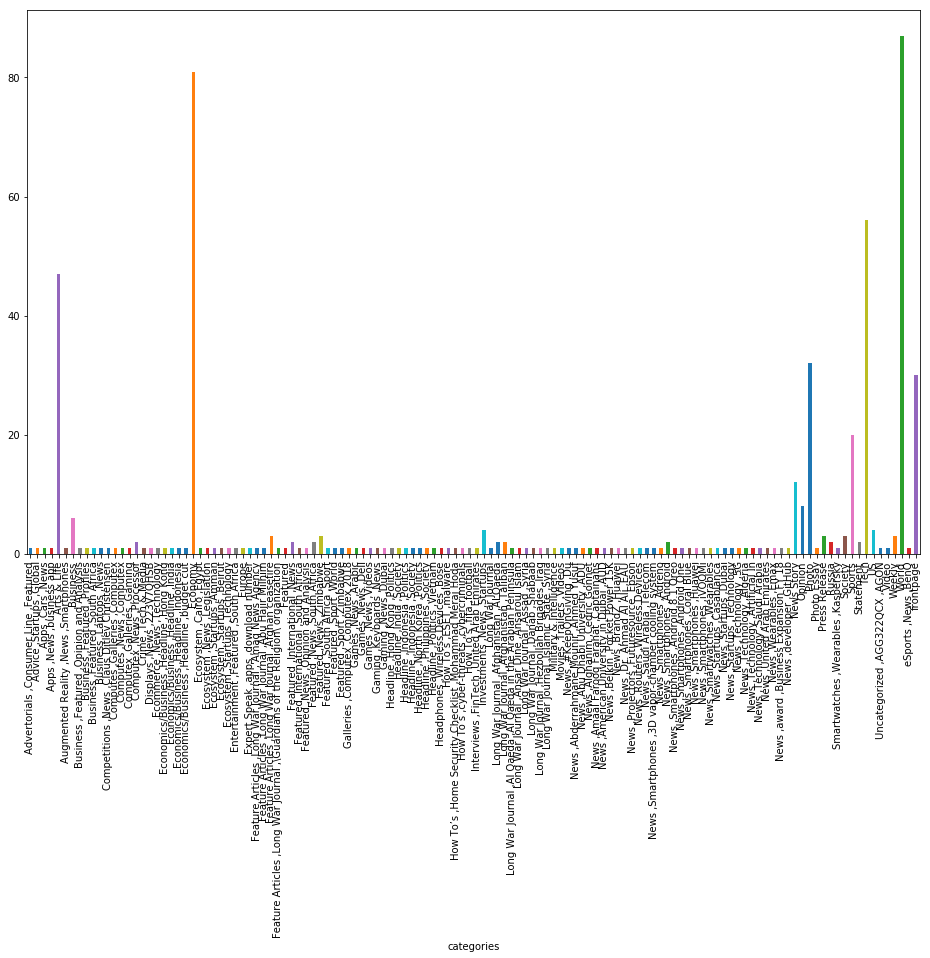

In [181]:
df.groupby('categories').body.count().plot.bar(ylim=0, figsize=(16,10))
plt.show()

In [161]:
df['cat_id'] = df['categories'].factorize()[0]

In [162]:
df.head(5)

,body,subject,language,categories,cat_id
31,Turkey has taken on the task to renovate a tra...,Turkey to renovate train station in Lebanon on...,English,Arts & Life,0
35,The owners of Madison Square Garden in New Yor...,Will Spherical Music Venues in London and Las ...,English,Opinion,1
39,A recent trend on social media in Turkey is th...,Turkish doctors become social media influencers,English,Photo,2
46,Rating agency Moody’s Investor Service said on...,Strong US dollar to increase credit risk for e...,English,Economy,3
55,Saudi authorities have launched a probe after ...,Saudis probe woman TV presenter over ‘indecent...,English,World,4


In [163]:
cat_id_df = df[['categories', 'cat_id']].drop_duplicates().sort_values('cat_id')
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'categories']].values)

In [164]:
df.shape

(517, 5)

In [165]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(df.body).toarray()
# labels = df.cat_id
print(len(features), len(labels), len(df.index))

(601, 601, 517)


In [167]:
# xtrain, xtest, ytrain, ytest, itrain, itest = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)

xtrain, xtest, ytrain, ytest = train_test_split(df['body'], df['categories'], test_size=0.2, random_state=42)

engines = [('LSVC', LinearSVC())]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(engines)))
for name, engine in engines:
    clf = make_pipeline(tfidf, engine)
    clf.fit(xtrain, ytrain)
    prediction = clf.predict(xtest)
    score = clf.score(xtest, prediction)
    
import pickle
with open('./pkl/lsvc.pickle', 'wb') as f:
    pickle.dump(clf, f)
    
print("{} \n{}".format(prediction, score))

[u'Economy' u'World' u'Economy' u'World' u'frontpage' u'Economy'
 u'Economy' u'News Story' u'Ecosystem ,Startups ,Amman'
 u'Featured ,News ,Opinion and Analysis' u'News ,Wearables ,Emax'
 u'Economy' u'World' u'Photo' u'Arts & Life' u'Arts & Life' u'World'
 u'World' u'World' u'World' u'Business' u'Tech' u'World'
 u'Investments ,News ,Startups' u'Arts & Life'
 u'Long War Journal ,Danab ,Shabaab' u'Economy' u'World'
 u'Augmented Reality ,News ,Smartphones' u'World'
 u'Featured ,International ,News' u'News Story'
 u'Featured ,News ,Zimbabwe' u'Arts & Life' u'Photo' u'World' u'US'
 u'frontpage' u'News Story' u'News Story' u'World' u'News Story' u'Sports'
 u'World' u'World' u'Press Release' u'Economy' u'Tech' u'frontpage'
 u'Tech' u'Tech' u'Economy' u'World' u'Tech'
 u'Long War Journal ,Afghanistan ,Al Qaeda' u'World' u'Photo'
 u'News ,Smartphones ,Android' u'Tech' u'Investments ,News ,Startups'
 u'World' u'World' u'Economy' u'World' u'Arts & Life' u'Economy' u'World'
 u'Arts & Life' u'US' u

In [145]:
s = '''

‘Guys, you’ve got to hear this,” I said. I was sitting in front of my computer one day in July 2012, with one eye on a screen of share prices and the other on a live stream of the House of Commons Treasury select committee hearings. As the Barclays share price took a graceful swan dive, I pulled my headphones out of the socket and turned up the volume so everyone could hear. My colleagues left their terminals and came around to watch BBC Parliament with me.

It didn’t take long to realise what was happening. “Bob’s getting murdered,” someone said.

Bob Diamond, the swashbuckling chief executive of Barclays, had been called before the committee to explain exactly what his bank had been playing at in regards to the Libor rate-fixing scandal. The day before his appearance, he had made things very much worse by seeming to accuse the deputy governor of the Bank of England of ordering him to fiddle an important benchmark, then walking back the accusation as soon as it was challenged. He was trying to turn on his legendary charm in front of a committee of angry MPs, and it wasn’t working. On our trading floor, in Mayfair, calls were coming in from all over the City. Investors needed to know what was happening and whether the damage was reparable.

A couple of weeks later, the damage was done. The money was gone, Diamond was out of a job and the market, as it always does, had moved on. We were left asking ourselves: How did we get it so wrong?

'''

In [146]:
say = clf.predict([s])
score = clf.score([s], say)
print(say[0], score)

(u'Economy', 1.0)
